In [1]:
import os                       # for working with files

import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
with ZipFile ('/content/drive/My Drive/melanom.zip','r') as zipObj:
  zipObj.extractall('melanom')

In [5]:
from google.colab import files
!zip -r /content/melanom.zip /content/melanom
files.download('/content/drive/My Drive/melanom.zip')

Streaming output truncated to the last 5000 lines.
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_4514.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_1612.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_3812.jpg (deflated 1%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_614.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_1276.jpg (deflated 3%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_4099.jpg (deflated 2%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_432.jpg (deflated 3%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_1154.jpg (deflated 4%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_672.jpg (deflated 1%)
  adding: content/melanom/melanoma_cancer_dataset/train/benign/melanoma_1847.jpg (deflated 2%)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
train_dir = 'melanom/melanoma_cancer_dataset/train'
skin = os.listdir(train_dir)
skin

['benign', 'malignant']

In [7]:
# Number of images for each diseas
nums_train = {}
nums_val = {}
for s in skin:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
benign,5000
malignant,4605


In [8]:
# Function to show image
train = ImageFolder(train_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

Modeling

In [9]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 25 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2,
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         shear_range=0.2,
                                                         zoom_range=0.2,

                                                         fill_mode="nearest",
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(train_dir, subset='training', target_size=(224, 224), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=True)

test_data = valid_gen.flow_from_directory(train_dir, subset='validation', target_size=(224, 224), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=False)

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


freezing nescessary pararametres

In [10]:
import tensorflow_hub as hub
def get_from_hub(model_url):
    inputs = tf.keras.Input((batch_size,224, 224, 3))
    hub_module = hub.KerasLayer(model_url,trainable=False)
    outputs = hub_module(inputs)
    return tf.keras.Model(inputs, outputs)
def name_and_freeze(model,name=""):
    for layer in model.layers[:]:
      layer.trainable = False
    for layer in model.layers:
        layer._name = layer.name + str(name)

def se_block(inputs):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=len(train_data.class_indices.keys()), activation="relu")(x)
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x
def dilation_block(inputs,dilation_rates):
    outputs = []
    for dilation_rate in dilation_rates:
        x = tf.keras.layers.Conv2D(filters=len(train_data.class_indices.keys()), kernel_size=3, strides=1, padding="same", dilation_rate=dilation_rate)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        outputs.append(x)
    x = tf.keras.layers.Concatenate(axis=-1)(outputs)
    return x

In [12]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow
import glob
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras import layers
!pip install --quiet vit-keras
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.6 MB/s eta 0:00:00


Importing Vit

In [13]:
vit_big = vit.vit_b32(
        image_size = 224,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        )

353253686/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [ ]:
# vit_large = vit.vit_l32(
#         image_size = 224,
#         activation = 'sigmoid',
#         pretrained = True,
#         include_top = False,
#         pretrained_top = False,
#         )

1226658854/1226658854 [==============================] - 72s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Fine-tuning vit

In [14]:
# name_and_freeze(vit_large,'vit_large_')
name_and_freeze(vit_big,'vit_big_')
from tensorflow.keras import regularizers
x =vit_big.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
# x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x_vit_big = Dense(128, activation='relu')(x)

# x =vit_large.output
# x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
# x = Dense(32, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
# x=Dense(256,activation='relu')(x)
# x_vit_large = Dense(128, activation='relu')(x)

importing cnn models

In [15]:
densenet=tf.keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False, weights='imagenet')

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
print(densenet.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [ ]:
# vgg19=tf.keras.applications.vgg19.VGG19(input_shape=(224,224,3),include_top=False, weights='imagenet')

In [ ]:
# vgg16=tf.keras.applications.vgg16.VGG16(input_shape=(224,224,3),include_top=False, weights='imagenet')

In [16]:
name_and_freeze(densenet,'densenet_')

In [17]:
def get_model(base_model):
    x = tf.keras.layers.GlobalAveragePooling2D()(se_block(dilation_block(base_model.output,[2,3,5,7])))
    x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    # x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
    #                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dense(256,activation='relu')(x)
    return Dense(128,activation='relu')(x)

fine tuning CNN models

In [18]:
x_densenet = get_model(densenet)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Define the DenseNet121 model
densenet = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Function to create a new model using the provided base model
def get_model(base_model):
    x = tf.keras.layers.GlobalAveragePooling2D()(se_block(dilation_block(base_model.output,[2,3,5,7])))
    x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dense(256,activation='relu')(x)
    return Dense(128,activation='relu')(x)

# Define the number of classes
num_classes = 2  # Example number of classes

# Create a new model using the DenseNet121 base model
x_densenet = get_model(densenet)


constructing full model

In [20]:
from tensorflow.keras.layers import concatenate
concatenated = concatenate([x_densenet, x_vit_big])
bigmodel_prediction = Dense(len(train_data.class_indices), activation='softmax')(concatenated)
model = Model([densenet.input, vit_big.input], bigmodel_prediction)
from tensorflow.keras.utils import plot_model
trainable_params = sum([v.numpy().size for v in model.trainable_variables])
non_trainable_params = sum([v.numpy().size for v in model.non_trainable_variables])
print("trainable parametres: "+ str(trainable_params) + " non trainable parametres: "+ str(non_trainable_params))

trainable parametres: 7428308 non trainable parametres: 87540448


custom generator

In [21]:
def generator_two_img(gen):
    while True:
        X1i = gen.next()
        yield [X1i[0],X1i[0]], X1i[1]

training model

In [22]:
model.compile(loss="categorical_crossentropy",optimizer=tf.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
batch_size=64
history = model.fit(
    generator_two_img(train_data),
    validation_data=generator_two_img(test_data),
    validation_steps=test_data.n//batch_size,
    validation_batch_size=batch_size,
    steps_per_epoch=train_data.n//batch_size,
    batch_size=batch_size,
    epochs=20,
)

Epoch 1/20
120/120 [==============================] - 271s 1s/step - loss: 0.6858 - accuracy: 0.8663 - val_loss: 0.5852 - val_accuracy: 0.8635
Epoch 2/20
120/120 [==============================] - 170s 1s/step - loss: 0.4649 - accuracy: 0.9169 - val_loss: 0.6154 - val_accuracy: 0.8998
Epoch 3/20
120/120 [==============================] - 159s 1s/step - loss: 0.3796 - accuracy: 0.9247 - val_loss: 0.4327 - val_accuracy: 0.8880
Epoch 4/20
120/120 [==============================] - 159s 1s/step - loss: 0.3215 - accuracy: 0.9278 - val_loss: 0.3970 - val_accuracy: 0.9160
Epoch 5/20
120/120 [==============================] - 167s 1s/step - loss: 0.2820 - accuracy: 0.9324 - val_loss: 0.3165 - val_accuracy: 0.9165
Epoch 6/20
120/120 [==============================] - 150s 1s/step - loss: 0.2492 - accuracy: 0.9377 - val_loss: 0.2674 - val_accuracy: 0.9338
Epoch 7/20
120/120 [==============================] - 164s 1s/step - loss: 0.2241 - accuracy: 0.9417 - val_loss: 0.2572 - val_accuracy: 0.9262

In [23]:
import tensorflow as tf

# Assuming 'test_data' is your ImageDataGenerator object
for images, labels in test_data:
    images_tensor = tf.convert_to_tensor(images)  # Convert images to tensor
    labels_tensor = tf.convert_to_tensor(labels)  # Convert labels to tensor
    # Now you can use images_tensor and labels_tensor as needed
    break  # This line is just for example to stop after one batch

In [24]:
all_images = []
all_labels = []

# Process the first 5 batches
for i, (images, labels) in enumerate(test_data):
    if i >= 20:  # Stop after 5 batches
        break

    # Convert images and labels to tensors
    images_tensor = tf.convert_to_tensor(images)
    labels_tensor = tf.convert_to_tensor(labels)

    # Optionally: append to lists or perform operations
    all_images.append(images_tensor)
    all_labels.append(labels_tensor)

In [25]:
# Create a TensorFlow dataset from the Keras generator
dataset = tf.data.Dataset.from_generator(
    lambda: test_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, test_data.num_classes])
)

# Iterate over the dataset
for images_tensor, labels_tensor in dataset.take(1):  # Take 1 batch
    print(images_tensor.shape)  # Tensor shape
    print(labels_tensor.shape)  # Tensor shape

(64, 224, 224, 3)
(64, 2)


In [26]:
# If preprocessing is needed, do it before converting to tensors
tensor_all = []
labels_all = []

for images in all_images:
  images = images / 255.0  # Normalize images if needed
  images_tensor = tf.convert_to_tensor(images)
  tensor_all.append(images_tensor)

for label in all_labels:

  label_tensor = tf.convert_to_tensor(label)
  labels_all.append(label_tensor)

In [27]:
all_images_batch = tf.concat(tensor_all, axis=0)
all_labels_batch = tf.concat(labels_all, axis=0)

In [28]:
all_images_batch.shape

TensorShape([1217, 224, 224, 3])

In [33]:
import numpy as np
from keras.models import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'X_test' is your input dataset and 'y_test' are your labels

# Create a new model that outputs activations from the first dense layer
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('dense').output)

# Get activations
intermediate_output = intermediate_layer_model.predict(all_images_batch)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for easy visualization
reduced_features = pca.fit_transform(intermediate_output)

# Plot
plt.figure(figsize=(4, 3))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1],c=all_labels_batch[:,0
                                                                                     ], alpha=0.5)
plt.colorbar(scatter)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Model Activations')
plt.show()

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=float32>]


In [34]:
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [32]:
# Example to modify assuming your second input is another tensor or modified version of the first
# Let's assume 'all_images_batch_2' is the second input, prepared similarly to 'all_images_batch'
intermediate_output = intermediate_layer_model.predict([all_images_batch, all_images_batch_2])


39/39 [==============================] - 8s 124ms/step


In [41]:
# Example assuming you need to prepare another set of images
# Modify this based on your actual requirements

# Suppose 'test_data_2' is another ImageDataGenerator object or similar data source
all_images_2 = []
for i, (images, _) in enumerate(test_data):
    if i >= 20:  # assuming you want the same number of batches
        break
    images_tensor = tf.convert_to_tensor(images)
    all_images_2.append(images_tensor)

# Concatenate all tensors to form a single batch (if needed)
all_images_batch_2 = tf.concat(all_images, axis=0)


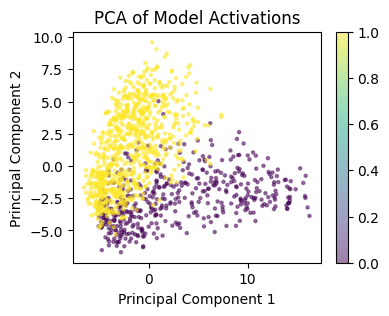

In [43]:
# Assuming now 'intermediate_output' correctly contains the output from the model
pca = PCA(n_components=2)  # Reduce to 2 dimensions for easy visualization
reduced_features = pca.fit_transform(intermediate_output)

# Plot
plt.figure(figsize=(4, 3))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=all_labels_batch[:,0], alpha=0.5, s=5)
plt.colorbar(scatter)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Model Activations')
plt.show()


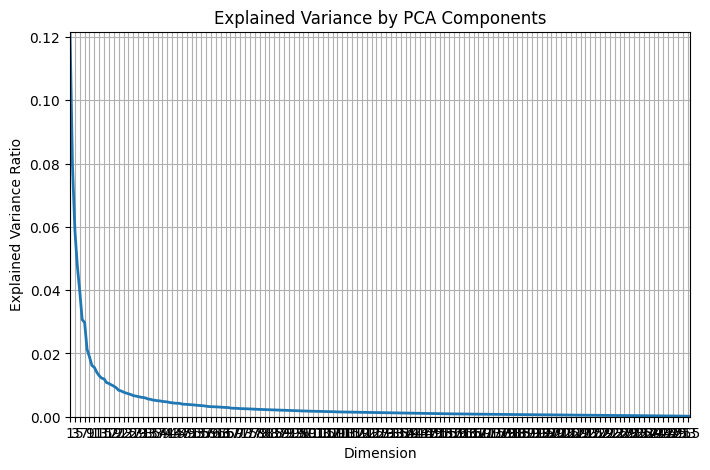

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'intermediate_output' contains your model activations or some other data

# Apply PCA
pca = PCA()  # Using all components by default
pca.fit(intermediate_output)

# Extract the number of components
n_components = pca.n_components_

# Generate a range for the x-axis that aligns with the component count
x_values = np.linspace(1, n_components, n_components)

# Plot the explained variance ratios
plt.figure(figsize=(8, 5))
plt.plot(x_values, pca.explained_variance_ratio_, linewidth=2)
plt.xlabel('Dimension')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.xticks(np.arange(1, n_components + 1, step=2))  # Set ticks at regular intervals
plt.xlim(1, n_components)  # Ensure x-axis starts at 1 and ends at the number of components
plt.ylim(0, np.max(pca.explained_variance_ratio_))  # Set y-axis limits based on the max variance ratio

# Ensuring the background is white and grid is visible
plt.gca().set_facecolor('white')
plt.grid(True)

plt.show()


performance evaluation

In [44]:
def prediction_generator(test_data):
    k=0
    for x in test_data:
        k+=len(x[1])
        yield [x[0],x[0]], x[1]
        if(k>=test_data.n):
            break

2/2 [==============================] - 0s 228ms/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.97      0.93      1000
   malignant       0.97      0.86      0.91       921

    accuracy                           0.92      1921
   macro avg       0.93      0.92      0.92      1921
weighted avg       0.93      0.92      0.92      1921

Confusion Matrix:
[[975  25]
 [126 795]]


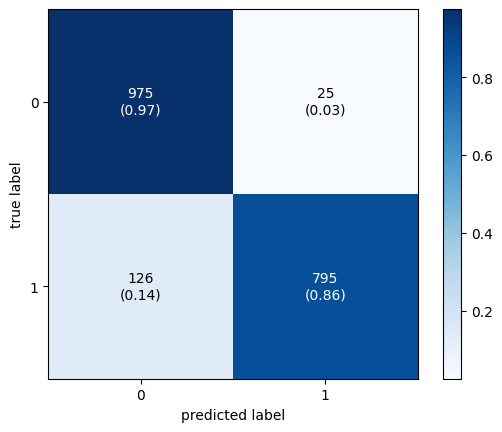

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Step 1: Generate predictions using the prediction_generator
y_true = []
y_pred = []
for images, labels in prediction_generator(test_data):
    true_labels = np.argmax(labels, axis=1)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

# Step 2: Calculate evaluation metrics
report = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())
cm1 = confusion_matrix(y_true, y_pred)

# Step 3: Print the evaluation metrics
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm1)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()



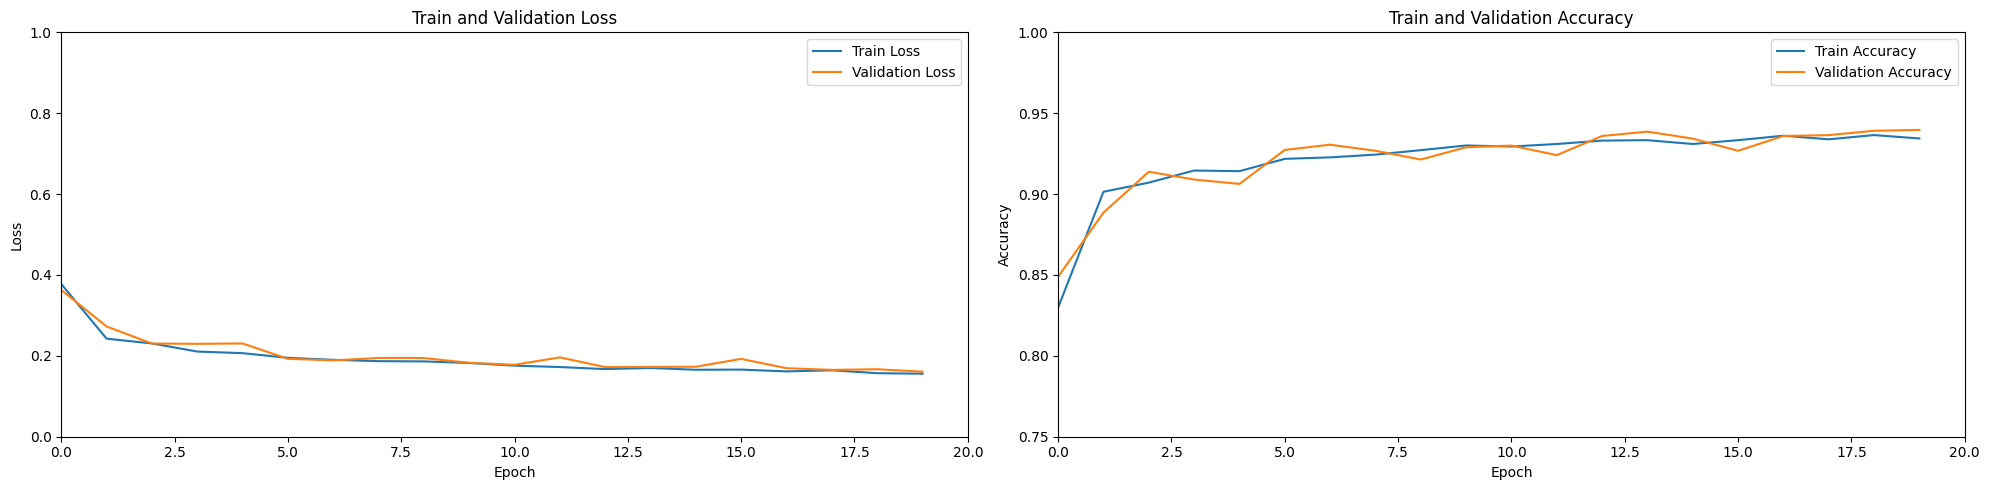

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, len(history.history['loss']))  # Adjust x-axis limit based on number of epochs
plt.ylim(0.0, 1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, len(history.history['accuracy']))  # Adjust x-axis limit based on number of epochs
plt.ylim(0.75, 1.0)
plt.legend()

plt.tight_layout()
plt.show()

MODEL Densenet121+ViT